# NLP: Sentiment analysis (v2)

ML Sample of Natural Language Processing.

- For environment test and confirmation.

## Dataset

Bag of Words Meets Bags of Popcorn
> Use Google's Word2Vec for movie reviews

https://www.kaggle.com/c/word2vec-nlp-tutorial

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from string import punctuation
from bs4 import BeautifulSoup
import contractions 
import re
from nltk.corpus import stopwords
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

from sklearn.svm import SVC


In [2]:
pd.set_option("display.max_colwidth", 200)

nltk.download('stopwords')

STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load Train Dataset
df_train = pd.read_csv(
    "./raw_data/labeledTrainData.tsv",
    delimiter="\t",
    na_filter=False
)

display(df_train.head(10))

,id,sentiment,review
0,5814_8,1,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just wa..."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds i..."
2,7759_3,0,"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, an..."
3,3630_4,0,"It must be assumed that those who praised this film (\the greatest filmed opera ever,\"" didn't I read somewhere?) either don't care for opera, don't care for Wagner, or don't care about anything e..."
4,9495_8,1,"Superbly trashy and wondrously unpretentious 80's exploitation, hooray! The pre-credits opening sequences somewhat give the false impression that we're dealing with a serious and harrowing drama, ..."
5,8196_8,1,"I dont know why people think this is such a bad movie. Its got a pretty good plot, some good action, and the change of location for Harry does not hurt either. Sure some of its offensive and gratu..."
6,7166_2,0,"This movie could have been very good, but comes up way short. Cheesy special effects and so-so acting. I could have looked past that if the story wasn't so lousy. If there was more of a background..."
7,10633_1,0,I watched this video at a friend's house. I'm glad I did not waste money buying this one. The video cover has a scene from the 1975 movie Capricorn One. The movie starts out with several clips of ...
8,319_1,0,"A friend of mine bought this film for £1, and even then it was grossly overpriced. Despite featuring big names such as Adam Sandler, Billy Bob Thornton and the incredibly talented Burt Young, this..."
9,8713_10,1,"<br /><br />This movie is full of references. Like \Mad Max II\"", \""The wild one\"" and many others. The ladybug´s face it´s a clear reference (or tribute) to Peter Lorre. This movie is a masterpie..."


In [4]:
# Methods preparation
_REGEX_PATTERN_HASHTAG = r"#\w+"
_REGEX_PATTERN_URL = r"http\S+"
_REGEX_PATTERN_MENTION = r"@\w+"


def count_text_length(text: str) -> int:
    """Count the given text length."""
    return len(text)


def count_uppercase_words(text: str) -> int:
    """Count of words in uppercase, that has length 2 or more."""
    return len([
        word for word in text.split()
        if word.isupper() and len(word) > 1
    ])


def count_total_punctuations(text: str) -> int:
    """Count of all punctuations in the text."""
    return len([
        char for char in text
        if char in punctuation
    ])


def count_hashtags_in_text(text: str) -> int:
    """Count the number of hashtags in the given text."""
    return len([
        word
        for word in text.split()
        if re.fullmatch(_REGEX_PATTERN_HASHTAG, word)
    ])


def count_urls_in_text(text: str) -> int:
    """Count the number of URLs in the given text."""
    return len([
        word
        for word in text.split()
        if re.fullmatch(_REGEX_PATTERN_URL, word)
    ])


def count_mentions_in_text(text: str) -> int:
    """Count the number of mentions in the given text."""
    return len([
        word
        for word in text.split()
        if re.fullmatch(_REGEX_PATTERN_MENTION, word)
    ])


def clean_text(text: str) -> str:
    """Clean text."""
    text = clean_text_html_tag_removing(text)
    text = _clean_text_expand_contractions(text)
    text = _clean_text_lowercase_conversion(text)
    text = _clean_text_non_alpha_numeric_replacing(text)
    text = _clean_text_stopwords_removing(text)
    return text
    

def clean_text_html_tag_removing(text: str) -> str:
    """Clean text with removing HTML tags."""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def _clean_text_expand_contractions(text: str) -> str:
    """Clean text with expansion contractions."""
    return contractions.fix(text)


def _clean_text_lowercase_conversion(text: str) -> str:
    """Clean text with lower case conversion."""
    return text.lower()


def _clean_text_non_alpha_numeric_replacing(text: str) -> str:
    """Clean text by replacing non-alphanumeric characters with spaces."""
    return re.sub("[^a-zA-Z0-9]", " ", text)


def _clean_text_stopwords_removing(text: str) -> str:
    """Clean text with removing stopwords."""
    words = text.split()
    words = [
        word for word in words if word not in STOPWORDS
    ]
    return ' '.join(words)


def evaluate_trained_model(
    model: BaseEstimator,
    X_val_data: list,
    y_val_data: list
) -> None:
    """Evaluate a trained Machine Learning model using various metrics

    This function provides:
    - Accuracy Score: Measures how accurately the class labels are predicted.
    - Precision Score: Evaluates how many of the items predicted as positive are actually positive.
    - Confusion Matrix: Provides a matrix representing TP, FP, FN, TN for each class.
    - Classification Report: Generates a detailed report including Precision, Recall, F1-score, and Support for each class.

    Args:
        model: Trained machine learning model.
        X_test_data, y_test_data: Test data and labels.
    """
    y_pred = model.predict(X_val_data)

    print(f"Evaluation: {model.__class__.__name__}\n")  
    print("Accuracy:", accuracy_score(y_val_data, y_pred))
    print("Precision:", precision_score(y_val_data, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val_data, y_pred))
    print("Classification Report:\n", classification_report(y_val_data, y_pred))


In [5]:
# EDA: Count text length
df_train['text_length'] = df_train['review'].apply(count_text_length)

print(df_train['text_length'].head())

0    2302
1     946
2    2449
3    2245
4    2231
Name: text_length, dtype: int64


In [6]:
# EDA: Count of words in uppercase
df_train['uppercase_words_count'] = df_train['review'].apply(count_uppercase_words)

print(df_train['uppercase_words_count'].head())
print(
    df_train[df_train['uppercase_words_count'] >= 1].shape[0]
)

0    9
1    4
2    2
3    0
4    0
Name: uppercase_words_count, dtype: int64
14662


In [7]:
# EDA: Count of all punctuations in the text
df_train['punctuations_count'] = df_train['review'].apply(
    clean_text_html_tag_removing
).apply(
    count_total_punctuations
)

print(df_train['punctuations_count'].head())

/tmp/ipykernel_1641/450432483.py:67: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


0    43
1    42
2    65
3    82
4    66
Name: punctuations_count, dtype: int64


In [8]:
# EDA: Count hashtags
df_train['hashtags_count'] = df_train['review'].apply(count_hashtags_in_text)

print(df_train['hashtags_count'].head())
print(
    df_train[df_train['hashtags_count'] >= 1].shape[0]
)

0    0
1    0
2    0
3    0
4    0
Name: hashtags_count, dtype: int64
81


In [9]:
# EDA: Count URLs
df_train['urls_count'] = df_train['review'].apply(count_urls_in_text)

print(df_train['urls_count'].head())
print(
    df_train[df_train['urls_count'] >= 1].shape[0]
)

0    0
1    0
2    0
3    0
4    0
Name: urls_count, dtype: int64
45


In [10]:
# EDA: Count mentions
df_train['mentions_count'] = df_train['review'].apply(count_mentions_in_text)

print(df_train['mentions_count'].head())
print(
    df_train[df_train['mentions_count'] >= 1].shape[0]
)

0    0
1    0
2    0
3    0
4    0
Name: mentions_count, dtype: int64
0


In [11]:
# Drop unnecessary columns and prepare meta-features array
df_train.drop(columns=['mentions_count'])

META_FEATURES = [
    'text_length',
    'uppercase_words_count',
    'punctuations_count',
    'hashtags_count',
    'urls_count',
]

is_positive_review: bool = df_train['sentiment'] == 1

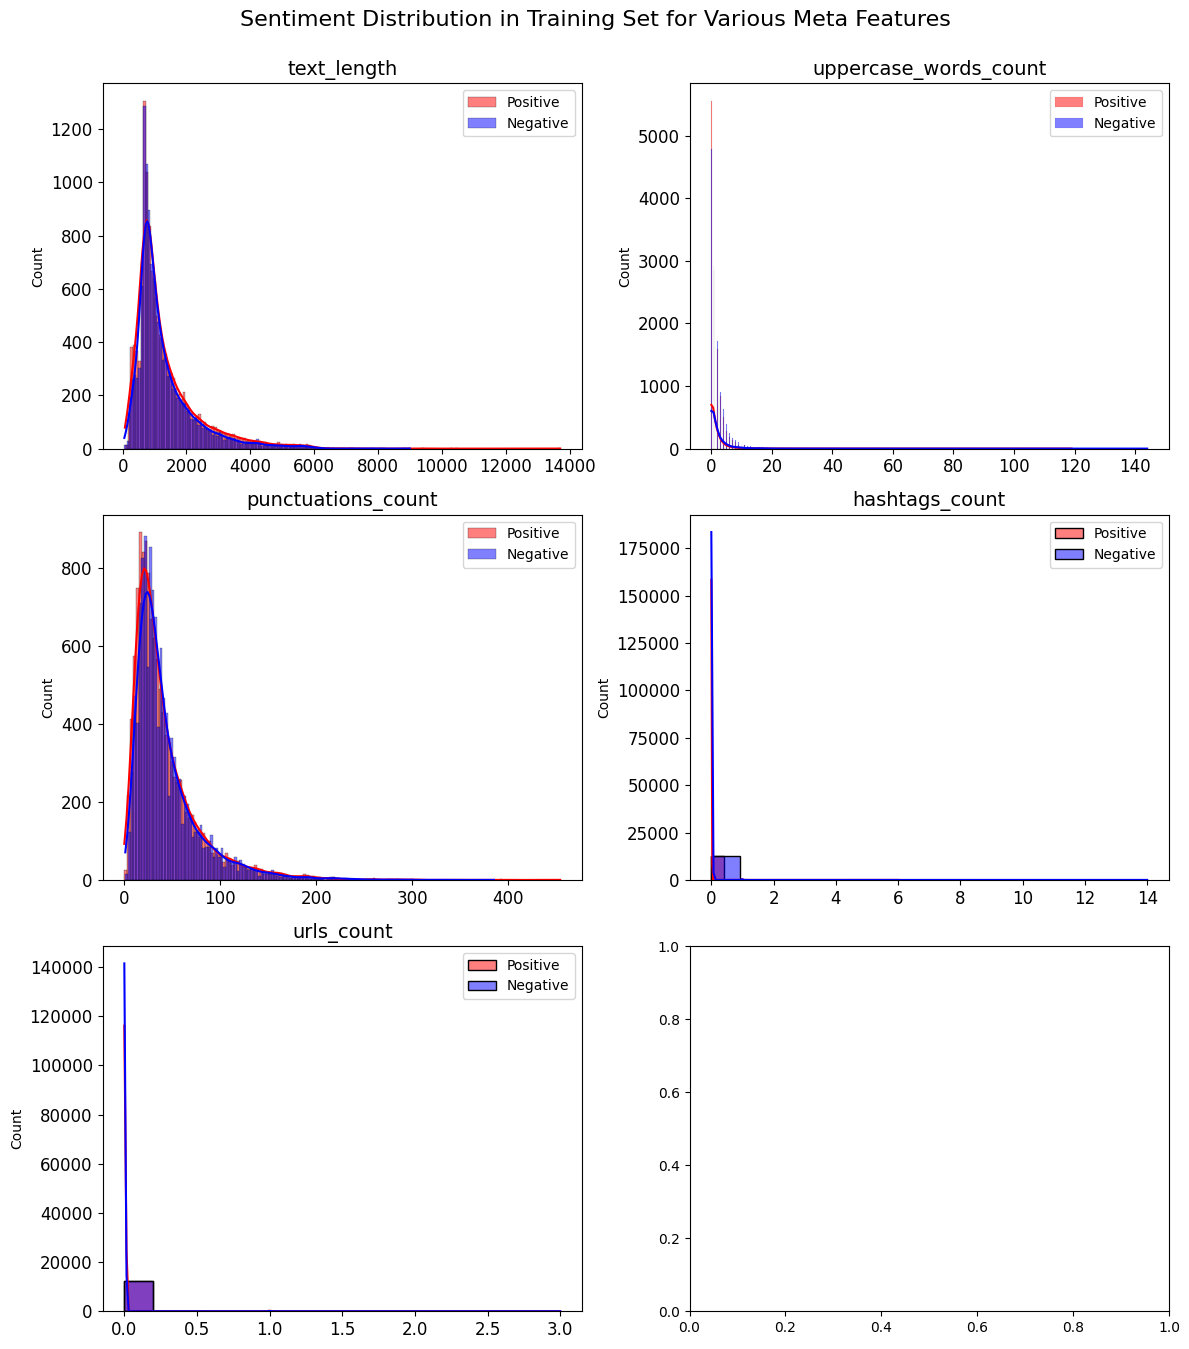

In [12]:
# Plot Sentiment Distribution in Training Set for Various Meta Features
fig, axes = plt.subplots(
    nrows=(int(len(META_FEATURES) / 2) + (len(META_FEATURES) % 2 > 0)),
    ncols=2,
    figsize=(12, 14)
)
fig.suptitle(
    'Sentiment Distribution in Training Set for Various Meta Features',
    fontsize=16
)
axes = axes.flatten()

for i, feature in enumerate(META_FEATURES):
    # Compare the distribution of positive and negative reviews (perform kernel density estimation)
    sns.histplot(
        df_train.loc[is_positive_review, feature],
        label='Positive',
        ax=axes[i],
        color='red',
        kde=True
    )
    sns.histplot(
        df_train.loc[~is_positive_review, feature],
        label='Negative',
        ax=axes[i],
        color='blue',
        kde=True
    )
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    axes[i].set_title(feature, fontsize=14)

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()

- There does not appear to be a significant difference in distribution between positive and negative reviews.

In [13]:
# Data Preprocessing: clean text
df_train['review'] = df_train['review'].apply(clean_text)

display(df_train.head(10))

/tmp/ipykernel_1641/450432483.py:67: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,id,sentiment,review,text_length,uppercase_words_count,punctuations_count,hashtags_count,urls_count,mentions_count
0,5814_8,1,stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty...,2302,9,43,0,0,0
1,2381_9,1,classic war worlds timothy hines entertaining film obviously goes great effort lengths faithfully recreate h g wells classic book mr hines succeeds watched film appreciated fact standard predictab...,946,4,42,0,0,0
2,7759_3,0,film starts manager nicholas bell giving welcome investors robert carradine primal park secret project mutating primal animal using fossilized dna like jurassik park scientists resurrect one natur...,2449,2,65,0,0,0
3,3630_4,0,must assumed praised film greatest filmed opera ever read somewhere either care opera care wagner care anything except desire appear cultured either representation wagner swan song movie strikes u...,2245,0,82,0,0,0
4,9495_8,1,superbly trashy wondrously unpretentious 80 exploitation hooray pre credits opening sequences somewhat give false impression dealing serious harrowing drama need fear barely ten minutes later neck...,2231,0,66,0,0,0
5,8196_8,1,know people think bad movie got pretty good plot good action change location harry hurt either sure offensive gratuitous movie like eastwood good form dirty harry liked pat hingle movie small town...,441,5,11,0,0,0
6,7166_2,0,movie could good comes way short cheesy special effects acting could looked past story lousy background story would better plot centers around evil druid witch linked woman gets migraines movie dr...,605,1,17,0,0,0
7,10633_1,0,watched video friend house glad waste money buying one video cover scene 1975 movie capricorn one movie starts several clips rocket blow ups related manned flight sibrel smoking gun short video cl...,728,1,21,0,0,0
8,319_1,0,friend mine bought film 1 even grossly overpriced despite featuring big names adam sandler billy bob thornton incredibly talented burt young film funny taking chisel hammering straight earhole use...,963,0,25,0,0,0
9,8713_10,1,movie full references like mad max ii wild one many others ladybug face clear reference tribute peter lorre movie masterpiece talk much future,242,1,16,0,0,0


In [14]:
# Feature Engineering: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10_000)

X = vectorizer.fit_transform(df_train['review'])
y = df_train['sentiment']

In [15]:
# Model Building: split data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [16]:
# Model Building: Support Vector Machine
model_svm = SVC()
model_svm.fit(X_train, y_train)

# Evaluation
evaluate_trained_model(
    model_svm,
    X_val,
    y_val
)

Evaluation: SVC

Accuracy: 0.8934
Precision: 0.8831018518518519
Confusion Matrix:
 [[2178  303]
 [ 230 2289]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      2481
           1       0.88      0.91      0.90      2519

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [17]:
# Load Test Dataset
df_test = pd.read_csv(
    "./raw_data/testData.tsv",
    delimiter="\t",
    na_filter=False
)

display(df_test.head())

,id,review
0,12311_10,"Naturally in a film who's main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there..."
1,8348_2,"This movie is a disaster within a disaster film. It is full of great action scenes, which are only meaningful if you throw away all sense of reality. Let's see, word to the wise, lava burns you; s..."
2,5828_4,"All in all, this is a movie for kids. We saw it tonight and my child loved it. At one point my kid's excitement was so great that sitting was impossible. However, I am a great fan of A.A. Milne's ..."
3,7186_2,"Afraid of the Dark left me with the impression that several different screenplays were written, all too short for a feature length film, then spliced together clumsily into this Frankenstein's mon..."
4,12128_7,"A very accurate depiction of small time mob life filmed in New Jersey. The story, characters and script are believable but the acting drops the ball. Still, it's worth watching, especially for the..."


In [18]:
# Test Data Preprocessing: Clean text
df_test['review'] = df_test['review'].apply(clean_text)

display(df_test.head())

/tmp/ipykernel_1641/450432483.py:67: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,id,review
0,12311_10,naturally film main themes mortality nostalgia loss innocence perhaps surprising rated highly older viewers younger ones however craftsmanship completeness film anyone enjoy pace steady constant c...
1,8348_2,movie disaster within disaster film full great action scenes meaningful throw away sense reality let us see word wise lava burns steam burns cannot stand next lava diverting minor lava flow diffic...
2,5828_4,movie kids saw tonight child loved one point kid excitement great sitting impossible however great fan milne books subtle hide wry intelligence behind childlike quality leading characters film sub...
3,7186_2,afraid dark left impression several different screenplays written short feature length film spliced together clumsily frankenstein monster best protagonist lucas creepy hard draw bead secondary ch...
4,12128_7,accurate depiction small time mob life filmed new jersey story characters script believable acting drops ball still worth watching especially strong images still even though first viewed 25 years ...


In [19]:
# Feature Engineering: TF-IDF Vectorization
X_test = vectorizer.transform(df_test['review'])

In [20]:
# Prediction: using SVC trained model
y_test_predicted = model_svm.predict(X_test)

In [21]:
df_final = pd.DataFrame({
    'id': df_test['id'],
    'sentiment': y_test_predicted
})

display(df_final)

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1
...,...,...
24995,2155_10,1
24996,59_10,1
24997,2531_1,0
24998,7772_8,1


In [22]:
print(
    df_final[df_final['sentiment'] == 1].shape[0]
)

12477


In [23]:
df_final.to_csv(
    'v2_submission.csv',
    index=False
)

- Result

> Score: 0.8826